In [2]:
import os
import random
import torch

import utils
import data_utils
import similarity

import matplotlib
from matplotlib import pyplot as plt

os.chdir("/volumes1/safeexplain/clip_diss/CLIP-dissect")


## Settings

In [3]:
clip_name = 'ViT-B/16'
target_name = 'resnet18_cifar'
target_layer = 'layer4'
d_probe = 'cifar100_val'
concept_set = 'data/20k.txt'
batch_size = 200
device = 'cuda'
pool_mode = 'avg'

save_dir = 'saved_activations'
similarity_fn = similarity.soft_wpmi

## Run CLIP-Dissect

In [4]:
utils.save_activations(clip_name = clip_name, target_name = target_name, target_layers = [target_layer], 
                       d_probe = d_probe, concept_set = concept_set, batch_size = batch_size, 
                       device = device, pool_mode=pool_mode, save_dir = save_dir)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 342/342 [01:17<00:00,  4.41it/s]


In [5]:
save_names = utils.get_save_names(clip_name = clip_name, target_name = target_name,
                                  target_layer = target_layer, d_probe = d_probe,
                                  concept_set = concept_set, pool_mode=pool_mode,
                                  save_dir = save_dir)

target_save_name, clip_save_name, text_save_name = save_names

similarities, target_feats = utils.get_similarity_from_activations(target_save_name, clip_save_name, 
                                                             text_save_name, similarity_fn)

with open(concept_set, 'r') as f: 
    words = (f.read()).split('\n')

pil_data = data_utils.get_data(d_probe)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2048/2048 [00:01<00:00, 1837.74it/s]


torch.Size([2048, 20000])


In [10]:
save_names

('saved_activations/imagenet_broden_resnet50_layer4.pt',
 'saved_activations/imagenet_broden_ViT-B16.pt',
 'saved_activations/20k_ViT-B16.pt')

In [9]:
target_feats.shape[1]

2048

## Visualize Results


 Layer:layer4 Neuron:2014
1st description: barbecue, sim:0.066
2nd description: chicken, sim:0.063
3rd description: stuffing, sim:0.061
5 most highly activating images in D_probe:


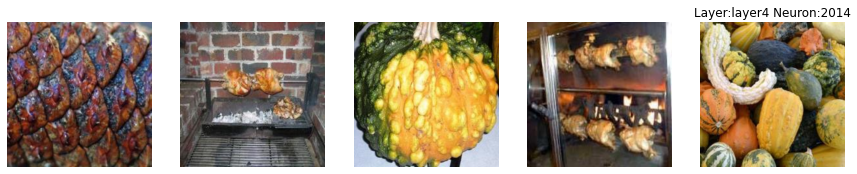


 Layer:layer4 Neuron:1387
1st description: parrot, sim:0.109
2nd description: bird, sim:0.090
3rd description: avian, sim:0.084
5 most highly activating images in D_probe:


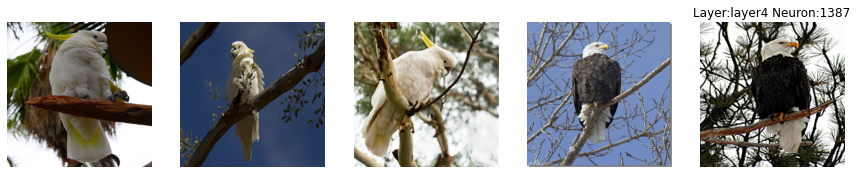


 Layer:layer4 Neuron:1619
1st description: observatory, sim:0.060
2nd description: landmarks, sim:0.052
3rd description: building, sim:0.052
5 most highly activating images in D_probe:


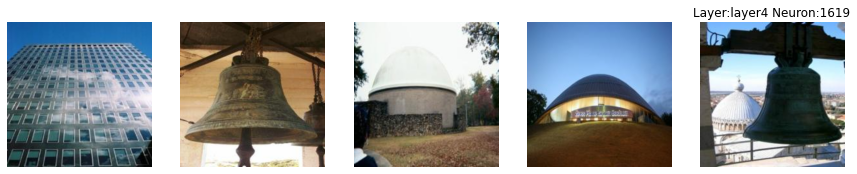


 Layer:layer4 Neuron:1480
1st description: mating, sim:0.063
2nd description: articulated, sim:0.043
3rd description: female, sim:0.043
5 most highly activating images in D_probe:


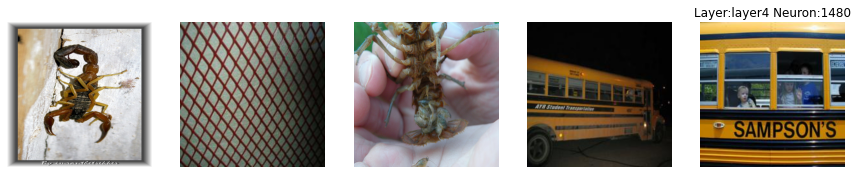


 Layer:layer4 Neuron:539
1st description: makeup, sim:0.056
2nd description: glitter, sim:0.042
3rd description: bleeding, sim:0.041
5 most highly activating images in D_probe:


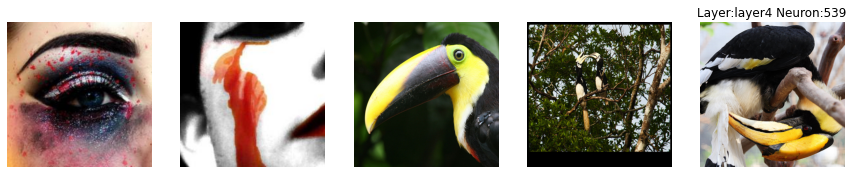


 Layer:layer4 Neuron:1615
1st description: shark, sim:0.124
2nd description: sharks, sim:0.101
3rd description: jaws, sim:0.093
5 most highly activating images in D_probe:


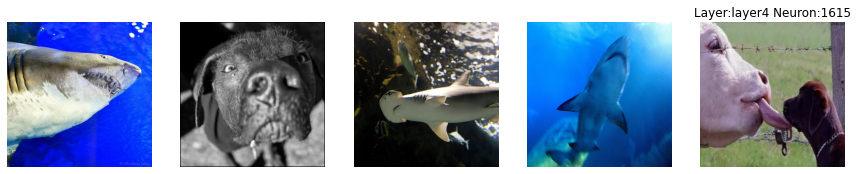


 Layer:layer4 Neuron:1556
1st description: airplanes, sim:0.114
2nd description: aircraft, sim:0.110
3rd description: flying, sim:0.104
5 most highly activating images in D_probe:


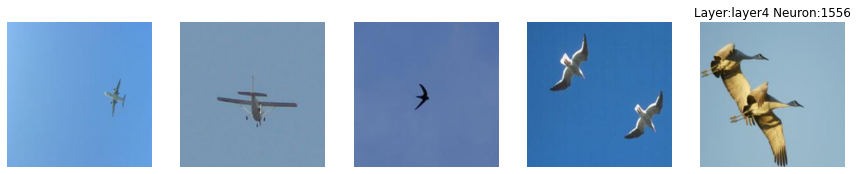


 Layer:layer4 Neuron:1171
1st description: gown, sim:0.080
2nd description: gowns, sim:0.077
3rd description: bridal, sim:0.076
5 most highly activating images in D_probe:


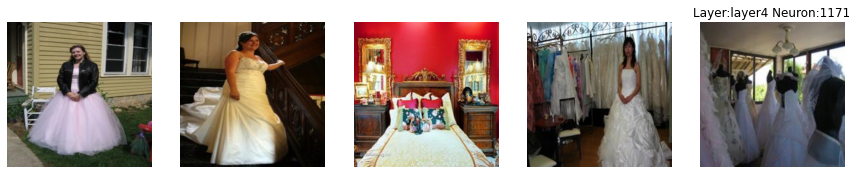


 Layer:layer4 Neuron:652
1st description: fluffy, sim:0.078
2nd description: fuzzy, sim:0.065
3rd description: fur, sim:0.064
5 most highly activating images in D_probe:


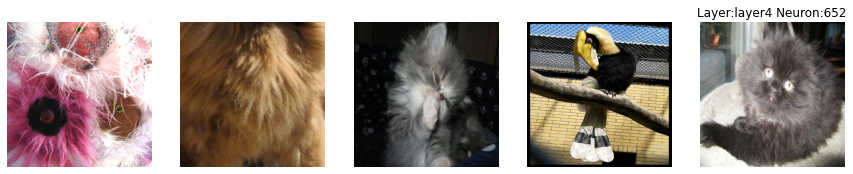


 Layer:layer4 Neuron:1313
1st description: pharmacy, sim:0.055
2nd description: pharmacies, sim:0.052
3rd description: wines, sim:0.051
5 most highly activating images in D_probe:


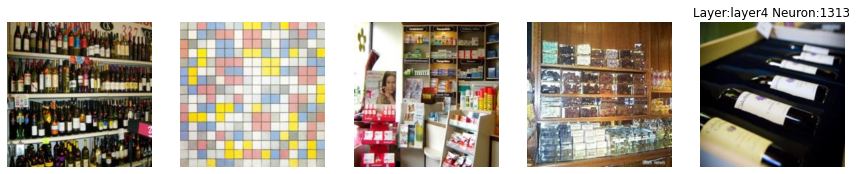

In [6]:
neurons_to_check = ids_to_check = random.sample([i for i in range(target_feats.shape[1])], k=10)
#neurons_to_check = torch.sort(torch.max(similarities, dim=1)[0], descending=True)[1][0:10]

ranks = ["1st", "2nd", "3rd"]
top_vals, top_ids = torch.topk(target_feats, k=5, dim=0)

for orig_id in ids_to_check:

    print('\n Layer:{} Neuron:{}'.format(target_layer, (int(orig_id))))
    vals, ids = torch.topk(similarities[orig_id], k=3, largest=True)
    for i in range(len(vals)):
        print("{} description: {}, sim:{:.3f}".format(ranks[i], words[int(ids[i])], vals[i]))
    
    print("5 most highly activating images in D_probe:")
    fig = plt.figure(figsize=(15, 7))
    for i, top_id in enumerate(top_ids[:, orig_id]):
        im, label = pil_data[top_id]
        im = im.resize([375,375])
        fig.add_subplot(1, 5, i+1)
        plt.imshow(im)
        plt.axis('off')
        
    plt.title('Layer:{} Neuron:{}'.format(target_layer, (int(orig_id))))
    plt.show()

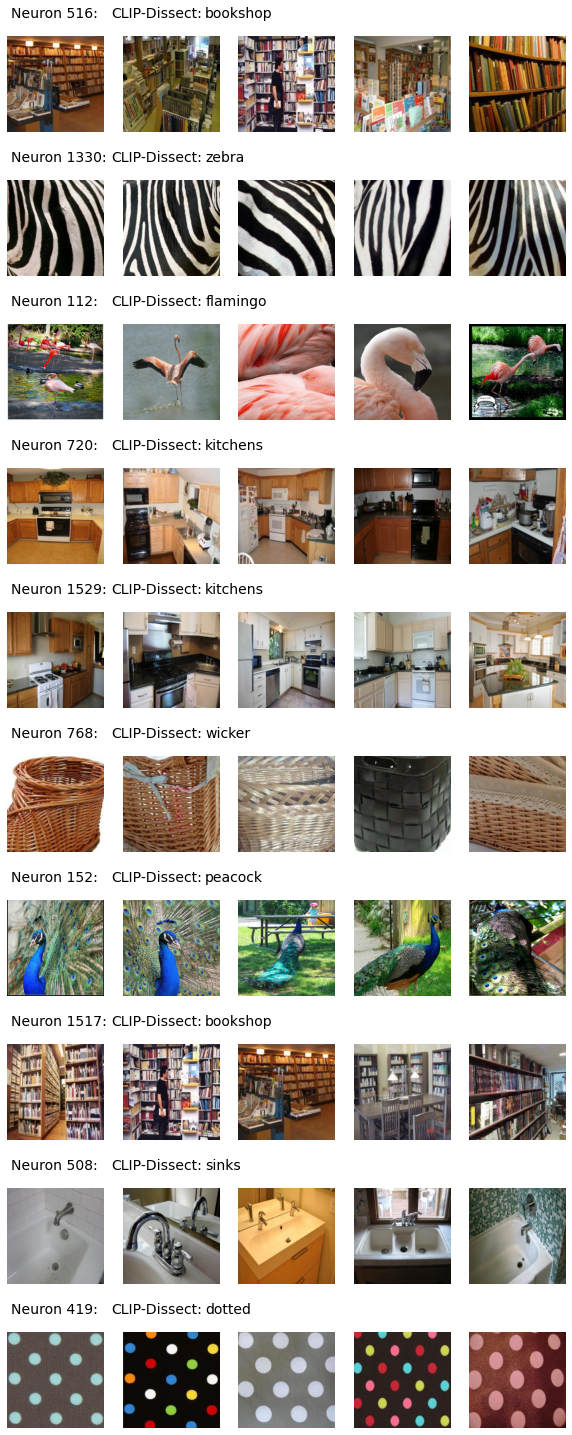

In [7]:
neurons_to_check = torch.sort(torch.max(similarities, dim=1)[0], descending=True)[1][0:10]
font_size=14
font = {'size'   : font_size}

matplotlib.rc('font', **font)

fig = plt.figure(figsize=[10, len(neurons_to_check)*2])#constrained_layout=True)
subfigs = fig.subfigures(nrows=len(neurons_to_check), ncols=1)
for j, orig_id in enumerate(neurons_to_check):
    vals, ids = torch.topk(similarities[orig_id], k=5, largest=True)
        
    subfig = subfigs[j]
    subfig.text(0.13, 0.96, "Neuron {}:".format(int(orig_id)), size=font_size)
    subfig.text(0.27, 0.96, "CLIP-Dissect:", size=font_size)
    subfig.text(0.4, 0.96, words[int(ids[0])], size=font_size)
    axs = subfig.subplots(nrows=1, ncols=5)
    for i, top_id in enumerate(top_ids[:, orig_id]):
        im, label = pil_data[top_id]
        im = im.resize([375,375])
        axs[i].imshow(im)
        axs[i].axis('off')
plt.show()